In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import json
import os
from PIL import Image
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
CUDA_LAUNCH_BLOCKING=1

In [4]:
def get_transform(train=True):
    if train:
        return A.Compose([
            A.Resize(height=800, width=1333),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            A.Resize(height=800, width=1333),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [5]:
class BDD100KDataset(Dataset):
    def __init__(self, root_dir, det_json, lane_dir, lane_polygon_json, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.lane_dir = lane_dir
        
        # Load detection annotations
        with open(det_json, 'r') as f:
            self.det_annotations = json.load(f)
            
        # Load lane polygon annotations
        with open(lane_polygon_json, 'r') as f:
            self.lane_polygons = json.load(f)
            
        # Create image to lane annotation mapping
        self.lane_poly_map = {ann['name']: ann.get('labels', []) for ann in self.lane_polygons}
        self.images = [os.path.join(root_dir, ann['name']) for ann in self.det_annotations]
        
        # Class mappings remain the same
        self.class_map = {
            'car': 1, 'bus': 2, 'person': 3, 'truck': 4, 'rider': 5,
            'bike': 6, 'motor': 7, 'traffic light': 8, 'traffic sign': 9, 'train': 10
        }
        
        self.lane_categories = {
            'road curb': 1, 'crosswalk': 2, 'double white': 3,
            'double yellow': 4, 'single white': 5, 'single yellow': 6, 'roadmark': 7
        }
        
        self.lane_styles = {'solid': 1, 'dashed': 2}

    def _create_lane_mask(self, image_shape, lane_labels):
        height, width = image_shape[:2]
        mask = np.zeros((height, width), dtype=np.uint8)
        
        for lane in lane_labels:
            category = lane['category'].lower()
            if 'poly2d' in lane and lane['poly2d']:
                points = lane['poly2d'][0]['vertices']
                points = np.array(points, dtype=np.int32).reshape((-1, 2))
                cv2.fillPoly(mask, [points], self.lane_categories.get(category, 1))
        
        return mask

    def _create_lane_direction_mask(self, image_shape, lane_labels):
        height, width = image_shape[:2]
        # Initialize with zeros - shape is [height, width, 2] for x,y directions
        direction_mask = np.zeros((2, height, width), dtype=np.float32) # Changed shape to [2, H, W]
        
        for lane in lane_labels:
            if 'poly2d' in lane and lane['poly2d']:
                points = lane['poly2d'][0]['vertices']
                if len(points) >= 2:
                    points = np.array(points, dtype=np.int32).reshape((-1, 2))
                    # Calculate direction vector
                    start_point = points[0]
                    end_point = points[-1]
                    direction = end_point - start_point
                    
                    # Normalize direction vector
                    norm = np.linalg.norm(direction)
                    if norm > 0:
                        direction = direction / norm
                        
                    # Create mask for this lane
                    lane_mask = np.zeros((height, width), dtype=np.uint8)
                    cv2.fillPoly(lane_mask, [points], 1)
                    
                    # Assign direction vectors to masked area
                    mask_indices = np.where(lane_mask > 0)
                    direction_mask[0, mask_indices[0], mask_indices[1]] = direction[0] # x direction
                    direction_mask[1, mask_indices[0], mask_indices[1]] = direction[1] # y direction
                    
        return direction_mask

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        img_path = self.images[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get image name for lane annotation lookup
        img_name = os.path.basename(img_path)
        
        # Load lane mask from directory
        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.lane_dir, mask_name)
        lane_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Get lane polygon annotations
        lane_labels = self.lane_poly_map.get(img_name, [])
        polygon_mask = self._create_lane_mask(image.shape, lane_labels)
        direction_mask = self._create_lane_direction_mask(image.shape, lane_labels)
        
        # Get detection annotations
        ann = self.det_annotations[idx]
        boxes = []
        labels = []
        
        if 'labels' in ann:
            for label in ann['labels']:
                if label['category'] in self.class_map:
                    x1 = label['box2d']['x1']
                    y1 = label['box2d']['y1']
                    x2 = label['box2d']['x2']
                    y2 = label['box2d']['y2']
                    boxes.append([x1, y1, x2, y2])
                    labels.append(self.class_map[label['category']])
        
        # Handle empty annotations
        if not boxes:
            boxes = [[0, 0, 1, 1]]
            labels = [0]
            
        boxes = np.array(boxes, dtype=np.float32)
        
        if self.transform:
            transformed = self.transform(
                image=image,
                masks=[lane_mask, polygon_mask, direction_mask[0], direction_mask[1]], # Split direction mask channels
                bboxes=boxes,
                labels=labels
            )
            
            image = transformed['image']
            lane_mask = transformed['masks'][0]
            polygon_mask = transformed['masks'][1]
            # Reconstruct direction mask from transformed channels
            direction_mask = np.stack([transformed['masks'][2], transformed['masks'][3]])
        
        target = {
            'boxes': torch.as_tensor(transformed['bboxes'], dtype=torch.float32),
            'labels': torch.as_tensor(transformed['labels'], dtype=torch.int64),
            'lane_mask': torch.as_tensor(lane_mask, dtype=torch.int64),
            'lane_polygon_mask': torch.as_tensor(polygon_mask, dtype=torch.int64),
            'lane_direction_mask': torch.as_tensor(direction_mask, dtype=torch.float32)
        }
        
        return image, target


    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.images[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get image name for lane annotation lookup
        img_name = os.path.basename(img_path)
        
        # Load lane mask from directory
        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.lane_dir, mask_name)
        lane_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Get lane polygon annotations
        lane_labels = self.lane_poly_map.get(img_name, [])
        polygon_mask = self._create_lane_mask(image.shape, lane_labels)
        direction_mask = self._create_lane_direction_mask(image.shape, lane_labels)
        
        # Get detection annotations
        ann = self.det_annotations[idx]
        boxes = []
        labels = []
        
        # Handle detection annotations
        if 'labels' in ann:  # Check if 'labels' key exists
            for label in ann['labels']:
                if label['category'] in self.class_map:
                    x1 = label['box2d']['x1']
                    y1 = label['box2d']['y1']
                    x2 = label['box2d']['x2']
                    y2 = label['box2d']['y2']
                    boxes.append([x1, y1, x2, y2])
                    labels.append(self.class_map[label['category']])
        
        # Handle empty annotations
        if not boxes:
            boxes = [[0, 0, 1, 1]]
            labels = [0]
            
        boxes = np.array(boxes, dtype=np.float32)
        
        if self.transform:
            transformed = self.transform(
                image=image,
                masks=[lane_mask, polygon_mask, direction_mask.transpose(1, 2, 0)],
                bboxes=boxes,
                labels=labels
            )
            
            image = transformed['image']
            lane_mask = transformed['masks'][0]
            polygon_mask = transformed['masks'][1]
            direction_mask = transformed['masks'][2].permute(2, 0, 1)  # Back to [2, H, W]
            boxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
            labels = torch.as_tensor(transformed['labels'], dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'lane_mask': torch.as_tensor(lane_mask, dtype=torch.int64),
            'lane_polygon_mask': torch.as_tensor(polygon_mask, dtype=torch.int64),
            'lane_direction_mask': torch.as_tensor(direction_mask, dtype=torch.float32)
        }
        
        return image, target

In [6]:
class EnhancedMTLModel(nn.Module):
    def __init__(self, num_classes=10, num_lane_classes=8):
        super(EnhancedMTLModel, self).__init__()
        
        # Initialize backbone with pretrained weights
        self.backbone = resnet_fpn_backbone('resnet50', pretrained=True)
        
        # Object Detection Branch
        self.object_detector = FasterRCNN(
            backbone=self.backbone,
            num_classes=num_classes + 1, # Add background class
            min_size=800,
            max_size=1333,
            rpn_pre_nms_top_n_train=2000,
            rpn_pre_nms_top_n_test=1000,
            rpn_post_nms_top_n_train=2000,
            rpn_post_nms_top_n_test=1000,
            rpn_nms_thresh=0.7,
            rpn_fg_iou_thresh=0.7,
            rpn_bg_iou_thresh=0.3,
            box_detections_per_img=100
        )
        
        # Lane Detection Branch
        self.lane_decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Increase number of lane classes to match dataset
        self.lane_segmentation = nn.Conv2d(64, num_lane_classes, kernel_size=1)
        self.lane_direction = nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, images, targets=None):
        if self.training and targets is not None:
            # Format validation
            for target in targets:
                if not all(k in target for k in ['boxes', 'labels', 'lane_mask', 'lane_polygon_mask', 'lane_direction_mask']):
                    raise ValueError("Missing required keys in targets")
                
                target['boxes'] = target['boxes'].float()
                if len(target['boxes']) == 0:
                    target['boxes'] = torch.zeros((0, 4), dtype=torch.float32, device=target['boxes'].device)

            # Object detection forward pass
            det_losses = self.object_detector(images, targets)

            # Lane detection forward pass
            features = self.backbone(torch.stack(images))
            lane_features = self.lane_decoder(features['0'])
            
            # Get lane predictions
            lane_logits = self.lane_segmentation(lane_features)
            direction_logits = self.lane_direction(lane_features)

            # Resize predictions to match target size
            target_size = targets[0]['lane_mask'].shape[-2:]
            lane_logits = F.interpolate(lane_logits, size=target_size, mode='bilinear', align_corners=False)
            direction_logits = F.interpolate(direction_logits, size=target_size, mode='bilinear', align_corners=False)

            # Stack lane masks and ensure valid indices
            lane_masks = torch.stack([t['lane_polygon_mask'] for t in targets])
            
            # Clamp indices to valid range instead of raising error
            lane_masks = torch.clamp(lane_masks, 0, self.lane_segmentation.out_channels - 1)

            # Calculate losses
            lane_seg_loss = F.cross_entropy(lane_logits, lane_masks)
            
            # Direction loss calculation
            direction_loss = 0
            for i, target in enumerate(targets):
                lane_exists = target['lane_polygon_mask'] > 0
                if lane_exists.any():
                    # Get predicted directions for pixels with lanes
                    pred_direction = direction_logits[i, :, lane_exists]  # [2, N]
                    
                    # Get ground truth directions for those pixels
                    true_direction = target['lane_direction_mask'][:, lane_exists]  # [2, N]
                    
                    # Calculate MSE loss for direction prediction
                    direction_loss += F.mse_loss(pred_direction, true_direction)
            
            direction_loss = direction_loss / len(targets)  # Average over batch


            # Combine losses
            losses = {
                'detection_loss': sum(loss for loss in det_losses.values()),
                'lane_seg_loss': lane_seg_loss,
                'direction_loss': direction_loss
            }
            losses['total_loss'] = losses['detection_loss'] + lane_seg_loss + 0.1 * direction_loss
            
            return losses

        else:
            # Inference mode
            det_results = self.object_detector(images)
            features = self.backbone(torch.stack(images))
            lane_features = self.lane_decoder(features['0'])
            
            # Get predictions
            lane_logits = self.lane_segmentation(lane_features)
            direction_logits = self.lane_direction(lane_features)
            
            # Resize predictions
            input_size = images[0].shape[-2:]
            lane_logits = F.interpolate(lane_logits, size=input_size, mode='bilinear', align_corners=False)
            direction_logits = F.interpolate(direction_logits, size=input_size, mode='bilinear', align_corners=False)
            
            # Add lane predictions to results
            lane_predictions = torch.argmax(lane_logits, dim=1)
            for i in range(len(det_results)):
                det_results[i]['lane_pred'] = lane_predictions[i]
                det_results[i]['lane_direction'] = direction_logits[i]
                
            return det_results

In [7]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [8]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    loss_meter = AverageMeter()
    det_loss_meter = AverageMeter()
    lane_loss_meter = AverageMeter()
    
    pbar = tqdm(data_loader, desc=f'Epoch {epoch}')
    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        losses = model(images, targets)
        
        total_loss = losses['total_loss']
        det_loss = losses['detection_loss']
        lane_loss = losses['lane_seg_loss']
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        loss_meter.update(total_loss.item())
        det_loss_meter.update(det_loss.item())
        lane_loss_meter.update(lane_loss.item())
        
        pbar.set_postfix({
            'total_loss': f'{loss_meter.avg:.4f}',
            'det_loss': f'{det_loss_meter.avg:.4f}',
            'lane_loss': f'{lane_loss_meter.avg:.4f}'
        })
    
    return loss_meter.avg

In [9]:
@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()
    loss_meter = AverageMeter()
    
    for images, targets in tqdm(data_loader, desc='Validating'):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Run inference with targets to compute losses
        losses = model(images, targets)
        
        # Handle different return types
        if isinstance(losses, list):
            # If it's a list of detection results
            loss = torch.tensor(0.0).to(device)
        elif isinstance(losses, dict):
            # If it's a dictionary of losses
            loss = losses.get('total_loss', torch.tensor(0.0).to(device))
        else:
            # Fallback to zero loss
            loss = torch.tensor(0.0).to(device)
        
        loss_meter.update(loss.item())
    
    return loss_meter.avg

In [10]:
def visualize_predictions(image, det_result, lane_pred, confidence_threshold=0.5):
    image = image.cpu().permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8)
    
    # Draw detection boxes
    for box, label, score in zip(det_result['boxes'], det_result['labels'], det_result['scores']):
        if score > confidence_threshold:
            box = box.cpu().numpy()
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, f"Class {label}", (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Overlay lane predictions
    lane_mask = lane_pred.cpu().numpy()
    lane_overlay = np.zeros_like(image)
    lane_overlay[lane_mask == 1] = [0, 0, 255]  # Red color for lanes
    
    alpha = 0.4
    image = cv2.addWeighted(image, 1, lane_overlay, alpha, 0)
    
    return image

In [11]:
def main():
    # Configuration
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {DEVICE}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA device count: {torch.cuda.device_count()}")
        print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
        print(f"CUDA memory allocated: {torch.cuda.memory_allocated(0)}")
        print(f"CUDA memory cached: {torch.cuda.memory_reserved(0)}")
    
    try:
        print("Initializing model...")
        model = EnhancedMTLModel(num_classes=10, num_lane_classes=8)
        print("Model initialized successfully")
        
        print("Moving model to device...")
        model = model.to(DEVICE)
        print("Model successfully moved to device")
        
    except Exception as e:
        print(f"Error during model initialization or moving to device: {str(e)}")
        raise
    BATCH_SIZE = 2
    NUM_EPOCHS = 10
    LEARNING_RATE = 1e-4
    
    # Initialize datasets
    train_dataset = BDD100KDataset(
        root_dir='/kaggle/input/100kds/100k_images_train/bdd100k/images/100k/train',
        det_json='/kaggle/input/bdddet/bdd100k/labels/det_20/det_train.json',
        lane_dir='/kaggle/input/bdd100k/bdd100k_lane_labels_trainval/bdd100k/labels/lane/masks/train',
        lane_polygon_json='/kaggle/input/bdd100k/bdd100k_lane_labels_trainval/bdd100k/labels/lane/polygons/lane_train.json',
        transform=get_transform(train=True)
    )

    val_dataset = BDD100KDataset(
        root_dir='/kaggle/input/100kds/100k_images_val/bdd100k/images/100k/val',
        det_json='/kaggle/input/bdddet/bdd100k/labels/det_20/det_val.json',
        lane_dir='/kaggle/input/bdd100k/bdd100k_lane_labels_trainval/bdd100k/labels/lane/masks/val',
        lane_polygon_json='/kaggle/input/bdd100k/bdd100k_lane_labels_trainval/bdd100k/labels/lane/polygons/lane_val.json',
        transform=get_transform(train=False)
    )
    
    # Create data loaders
    train_subset = Subset(train_dataset, range(200))
    val_subset = Subset(val_dataset, range(200))
    
    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
    
    # Initialize model
    model = EnhancedMTLModel(num_classes=10, num_lane_classes=2).to(DEVICE)
    
    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=2, verbose=True
    )
    
    # Training loop
    best_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(NUM_EPOCHS):
        # Train
        train_loss = train_one_epoch(model, optimizer, train_loader, DEVICE, epoch)
        train_losses.append(train_loss)
        
        # Validate
        val_loss = evaluate(model, val_loader, DEVICE)
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_loss': best_loss,
            }, 'best_model.pth')
        
        print(f'Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_history.png')
    plt.close()
    
    # Test visualization
    model.eval()
    images, targets = next(iter(val_loader))
    images = [img.to(DEVICE) for img in images]
    
    with torch.no_grad():
        predictions = model(images)
        
    # Visualize first image
    viz_image = visualize_predictions(images[0], predictions[0], predictions[0]['lane_pred'])
    plt.figure(figsize=(15, 8))
    plt.imshow(viz_image)
    plt.axis('off')
    plt.savefig('sample_prediction.png')
    plt.close()

if __name__ == '__main__':
    main()

Using device: cuda
CUDA available: True
CUDA device count: 2
CUDA device name: Tesla T4
CUDA memory allocated: 0
CUDA memory cached: 0
Initializing model...


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676

Model initialized successfully
Moving model to device...
Model successfully moved to device


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Validating: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Epoch 0: Train Loss = 1.7177, Val Loss = 0.0000


Validating: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Epoch 1: Train Loss = 1.4073, Val Loss = 0.0000


Validating: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


Epoch 2: Train Loss = 1.4236, Val Loss = 0.0000


Validating: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 3: Train Loss = 1.4395, Val Loss = 0.0000


Validating: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


Epoch 4: Train Loss = 1.4149, Val Loss = 0.0000


Validating: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


Epoch 5: Train Loss = 1.3894, Val Loss = 0.0000


Validating: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


Epoch 6: Train Loss = 1.3762, Val Loss = 0.0000


Validating: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Epoch 7: Train Loss = 1.3594, Val Loss = 0.0000


Validating: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


Epoch 8: Train Loss = 1.3416, Val Loss = 0.0000


Validating: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch 9: Train Loss = 1.3420, Val Loss = 0.0000


/tmp/ipykernel_30/869274609.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


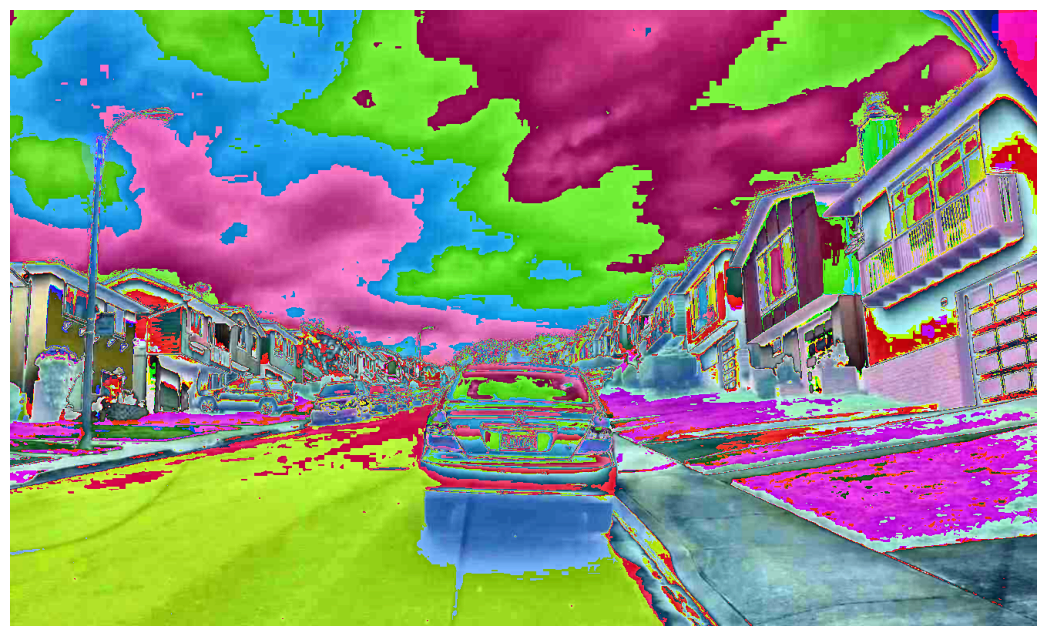

In [13]:
def test_single_image(model, image_path, device, transform):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply transformations
    transformed = transform(image=image)
    image = transformed['image'].to(device)
    
    # Run the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([image])[0]
    
    # Visualize the predictions
    viz_image = visualize_predictions(image, prediction, prediction['lane_pred'])
    
    # Display the image
    plt.figure(figsize=(15, 8))
    plt.imshow(viz_image)
    plt.axis('off')
    plt.show()

if __name__ == '__main__':
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = EnhancedMTLModel(num_classes=10, num_lane_classes=2).to(DEVICE)
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Define the transformation without bbox_params
    transform = A.Compose([
        A.Resize(height=800, width=1333),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    # Path to the test image
    test_image_path = '/kaggle/input/bdd100k/10k_images_test/bdd100k/images/10k/test/ac517380-00000000.jpg'
    
    # Test the model on the single image
    test_single_image(model, test_image_path, DEVICE, transform)